# Plotting cycle to work times

In [1]:
#!pip install HASS-data-detective # Install detective

In [2]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 2.4
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [3]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_list is not supported
YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 348 entities with data


First we extract all state changes for Gaby and Charles

In [4]:
people = ("person.charles","person.gaby",)
workplaces = ("Imperial", "Harris Westminster",)

In [5]:
results = db.fetch_all_data_of(people)
results.last_changed = pd.to_datetime(results.last_changed)
results.set_index('last_changed', inplace=True)
results.index.rename("time", inplace=True)
results.sort_index(inplace=True)
results

The returned Pandas dataframe has 26786 rows of data.


,domain,entity_id,state,attributes
time,,,,
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
2022-05-05 20:13:55.110599,None,person.gaby,home,None
...,...,...,...,...
2022-09-02 23:03:40.012767,None,person.charles,home,None
2022-09-03 08:52:23.430499,None,person.gaby,home,None
2022-09-03 08:52:23.430499,None,person.gaby,home,None


Person states have a lot of duplicates due to their attributes. Drop these, and use the times as the index:

In [6]:
results['time'] = results.index
results = results.drop_duplicates(subset=('domain', 'entity_id', 'state', 'time')).drop(['time', 'attributes'], axis=1)
results

,domain,entity_id,state
time,,,
2022-05-05 20:13:55.110599,None,person.gaby,home
2022-05-05 20:14:25.356517,None,person.charles,home
2022-05-06 06:55:21.896916,None,person.gaby,not_home
2022-05-06 07:10:36.457771,None,person.gaby,Central london
2022-05-06 07:29:27.015025,None,person.charles,not_home
...,...,...,...
2022-09-02 22:59:00.936924,None,person.gaby,not_home
2022-09-02 23:02:04.993106,None,person.gaby,home
2022-09-02 23:03:40.012767,None,person.charles,home


For each day, if the person went to work, store their arrival & departure times

In [17]:
dates = pd.date_range(min(results.index), max(results.index), normalize=True)

arrival_times = {person: pd.Series(dtype="timedelta64[ns]") for person in people}
leaving_times = {person: pd.Series(dtype="timedelta64[ns]") for person in people}

for date in dates:
    state_changes = results[date : date + np.timedelta64(1, 'D')]
    
    for person, workplace in zip(people, workplaces):
        this_person_changes = state_changes[state_changes.entity_id == person]
        if any(this_person_changes.state == workplace):
            workplace_states_ind = np.flatnonzero(this_person_changes.state == workplace)
            
            if len(this_person_changes) <= max(workplace_states_ind) + 1:
                continue # This day, they stayed at work...
            
            arrival_times[person][date] = this_person_changes.index[min(workplace_states_ind)] - date
            leaving_times[person][date] = this_person_changes.index[max(workplace_states_ind) + 1] - date
            
arrival_times = pd.DataFrame(arrival_times)
leaving_times = pd.DataFrame(leaving_times)

We're only interested in the morning and evening, so filter out WFH events or drunken evenings

In [18]:
arrival_times[arrival_times < np.timedelta64(5,'h')] = None
arrival_times[arrival_times > np.timedelta64(12,'h')] = None
leaving_times[leaving_times < np.timedelta64(12,'h')] = None

working_hours = (leaving_times - arrival_times)

<AxesSubplot:title={'center':'Arrival times at work'}, ylabel='Frequency'>

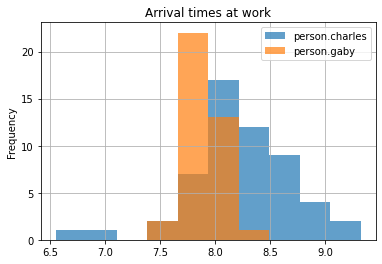

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

(arrival_times / np.timedelta64(1, 'h')).plot.hist(title="Arrival times at work", grid=True, alpha = 0.7)

<AxesSubplot:title={'center':'Departure times from work'}, ylabel='Frequency'>

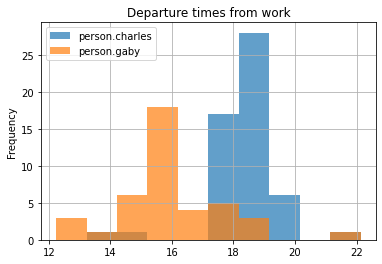

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

(leaving_times / np.timedelta64(1, 'h')).plot.hist(title="Departure times from work", grid=True, alpha = 0.7)

<AxesSubplot:title={'center':'Total hours at work'}, ylabel='Frequency'>

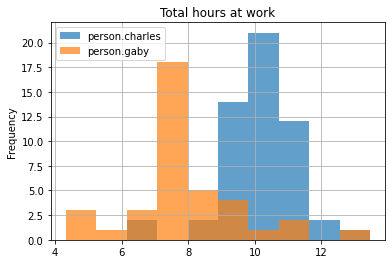

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

(working_hours / np.timedelta64(1, 'h')).plot.hist(title="Total hours at work", grid=True, alpha = 0.7)

In [22]:
arrival_times.mean()

person.charles   0 days 08:13:22.964584581
person.gaby      0 days 07:52:29.658345289
dtype: timedelta64[ns]

In [23]:
leaving_times.mean()

person.charles   0 days 18:20:27.370533555
person.gaby      0 days 15:55:38.914322487
dtype: timedelta64[ns]

In [24]:
working_hours.mean()

person.charles   0 days 10:06:45.867313722
person.gaby      0 days 07:57:38.288424131
dtype: timedelta64[ns]

In [25]:
arrival_times.median()

person.charles      0 days 08:11:28.493787
person.gaby      0 days 07:53:07.139199500
dtype: timedelta64[ns]

In [26]:
leaving_times.median()

person.charles   0 days 18:22:19.199715500
person.gaby         0 days 15:43:56.631089
dtype: timedelta64[ns]

In [27]:
working_hours.median()

person.charles   0 days 10:07:43.046489500
person.gaby         0 days 07:49:51.766933
dtype: timedelta64[ns]